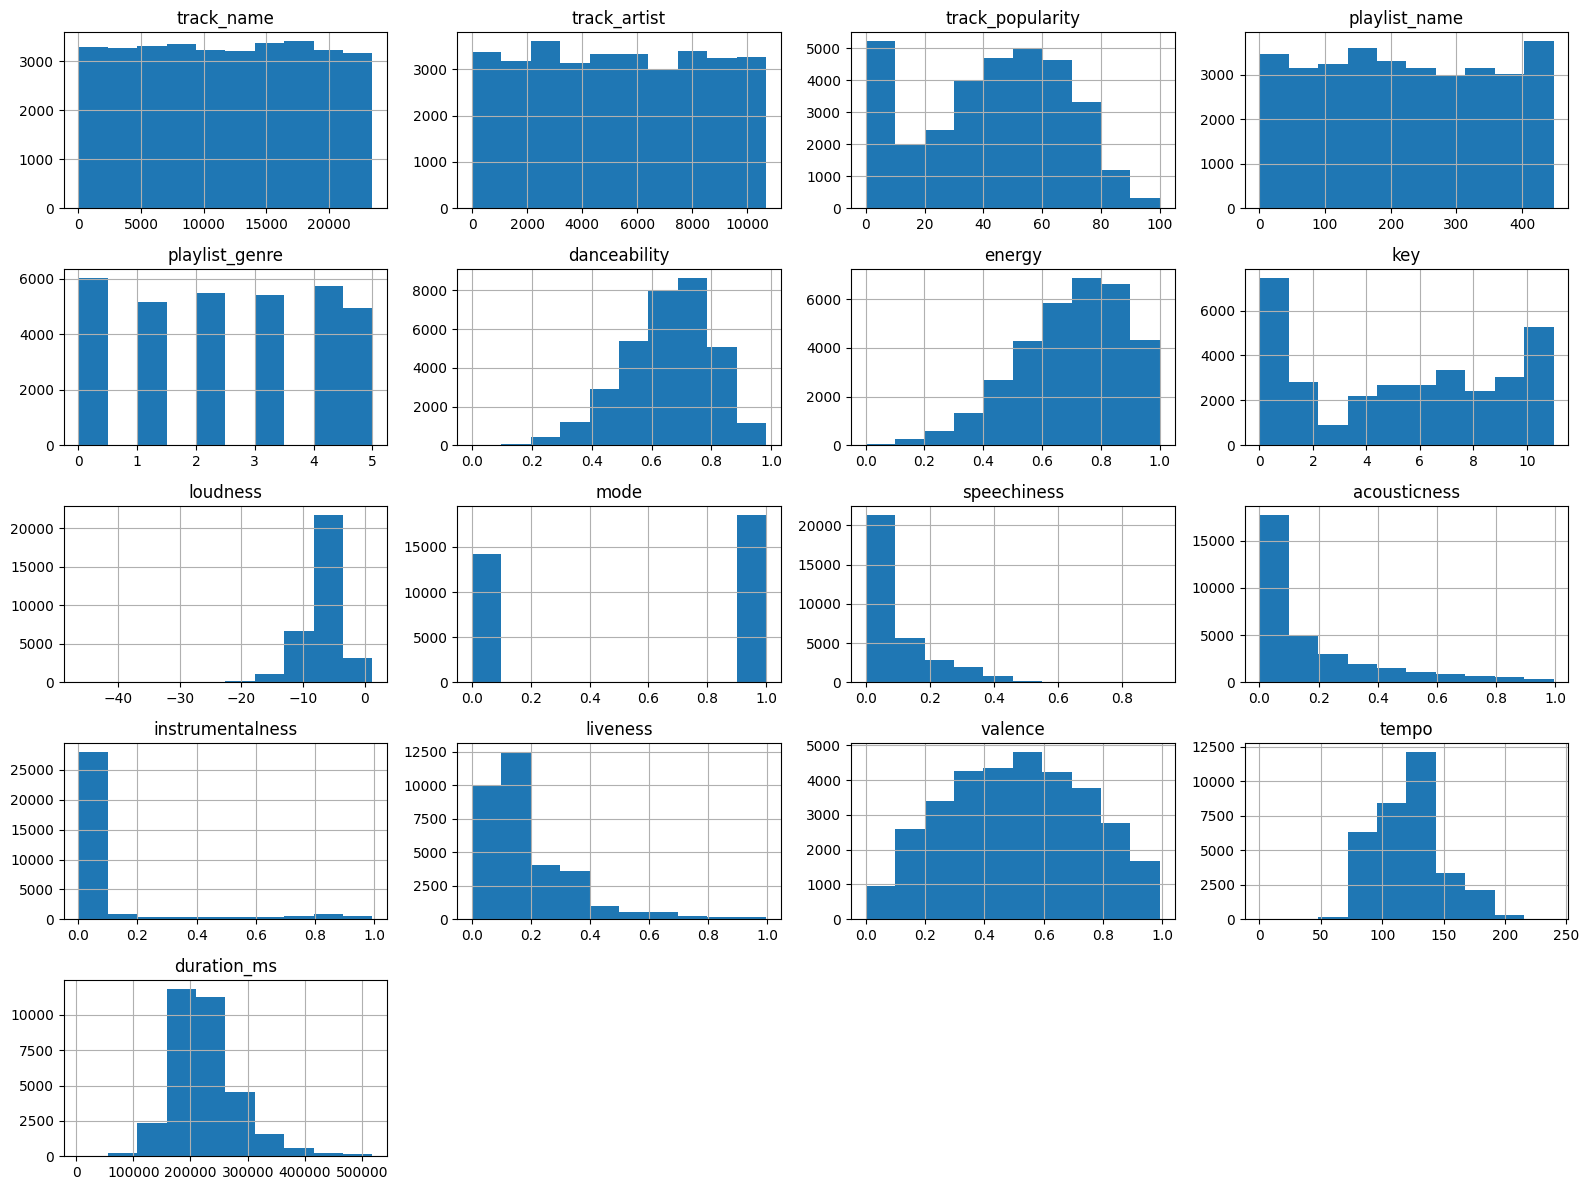

<Figure size 1600x1000 with 0 Axes>

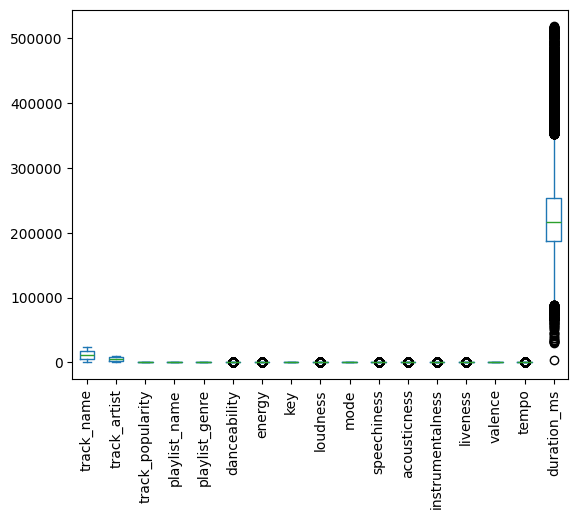

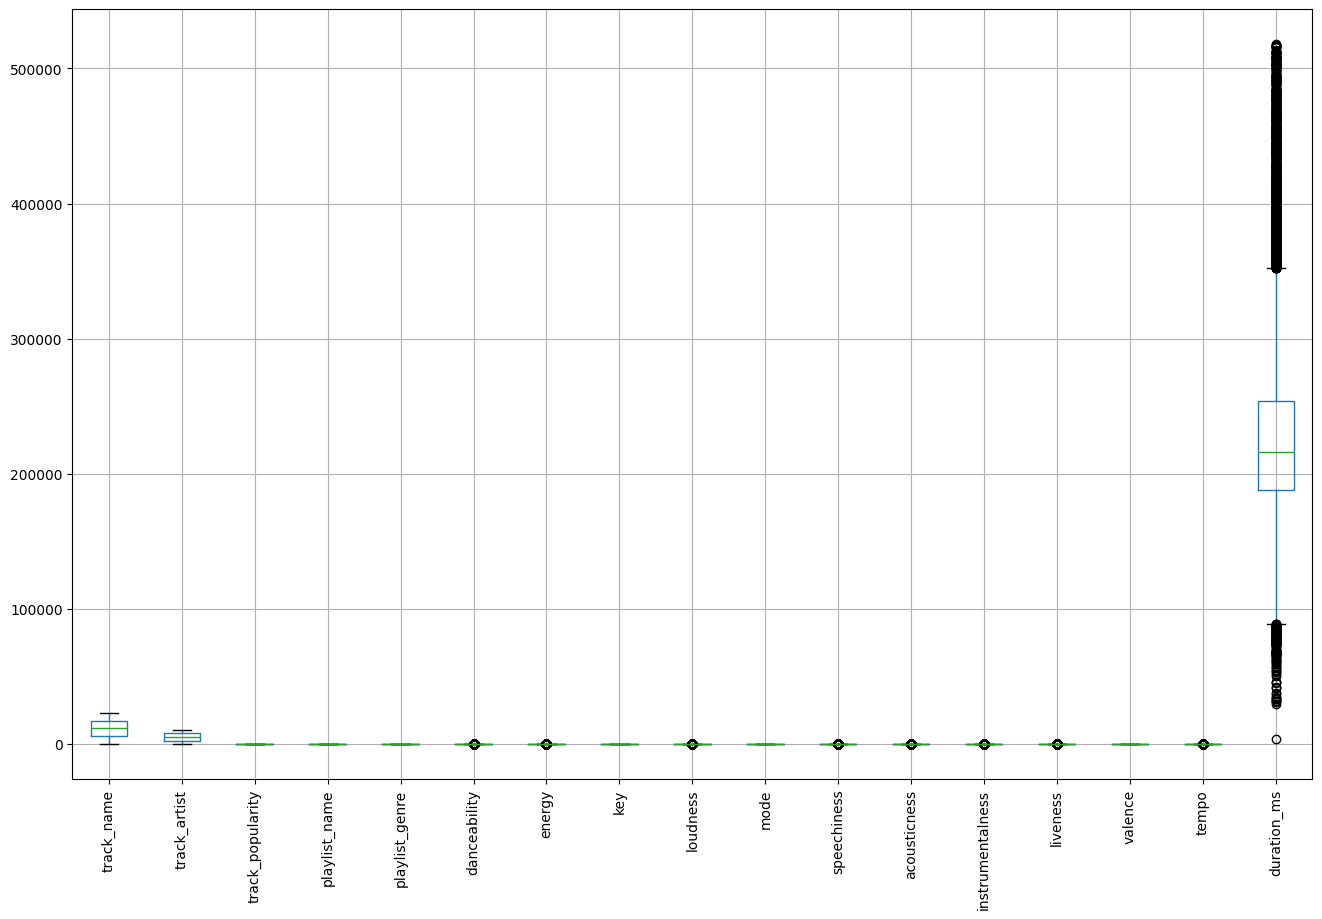

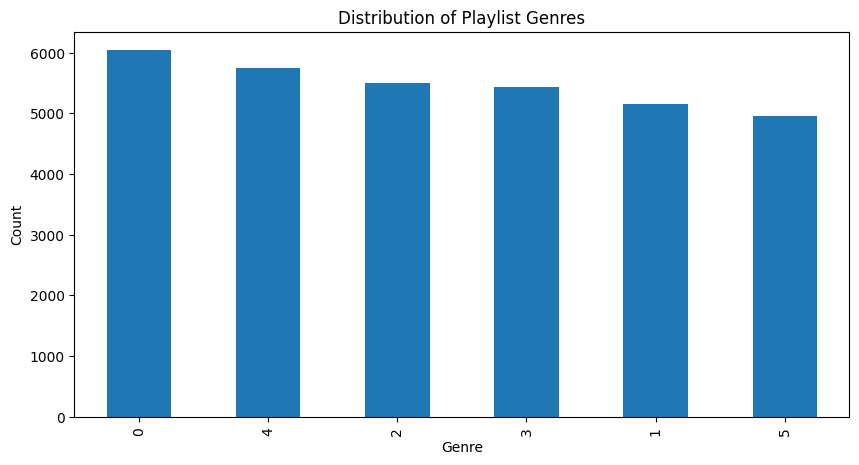

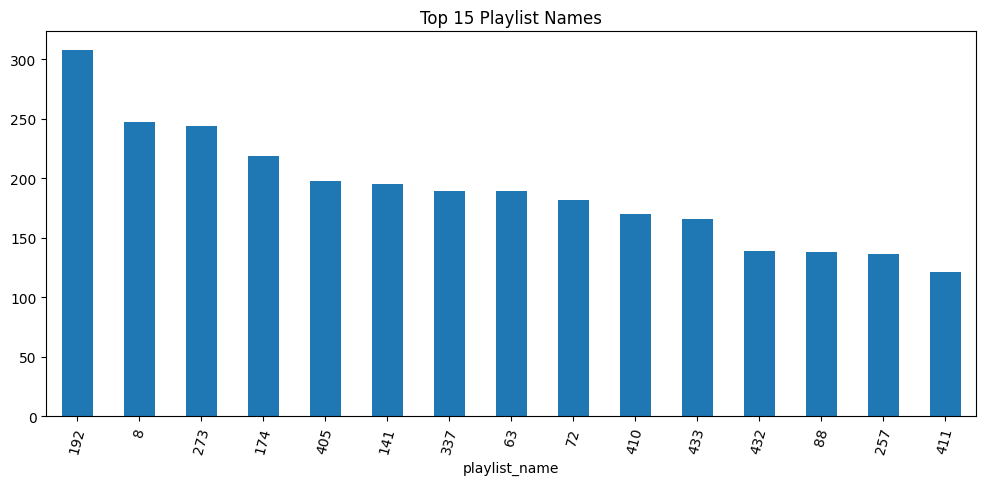

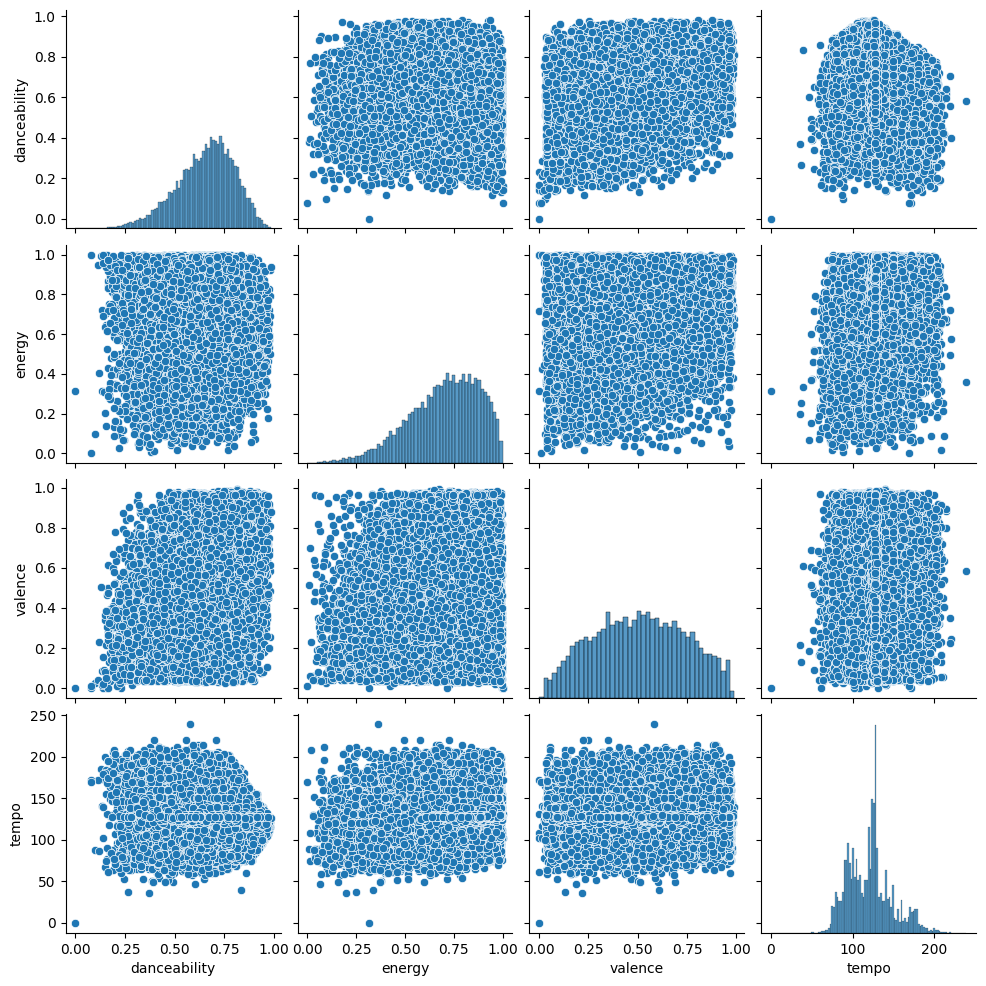

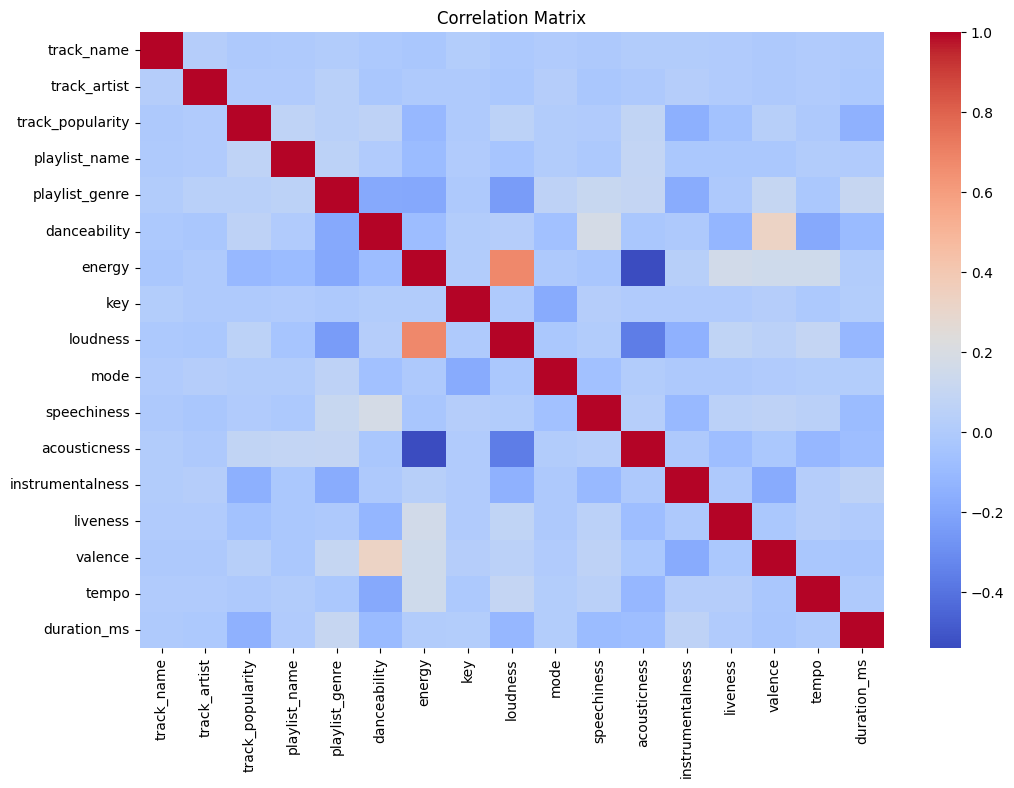

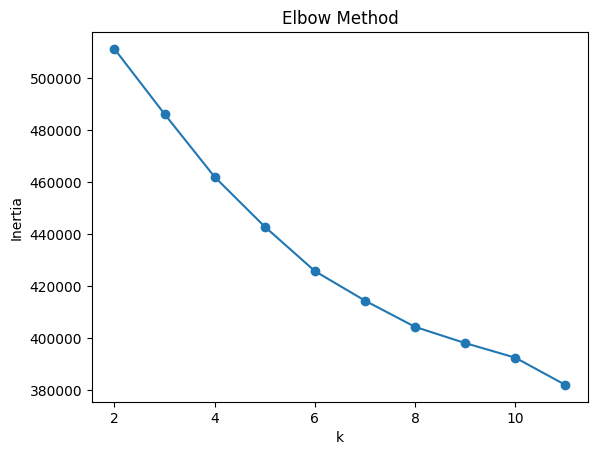

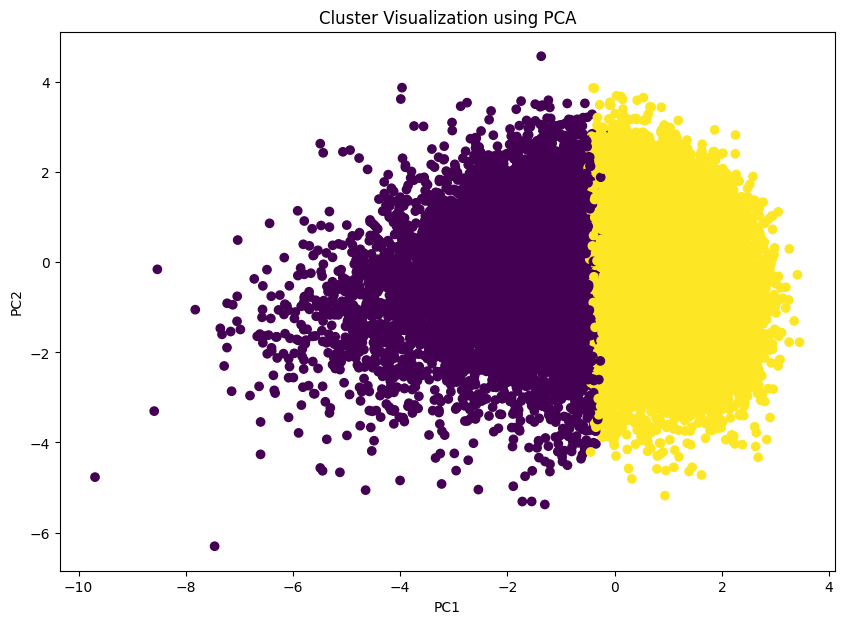

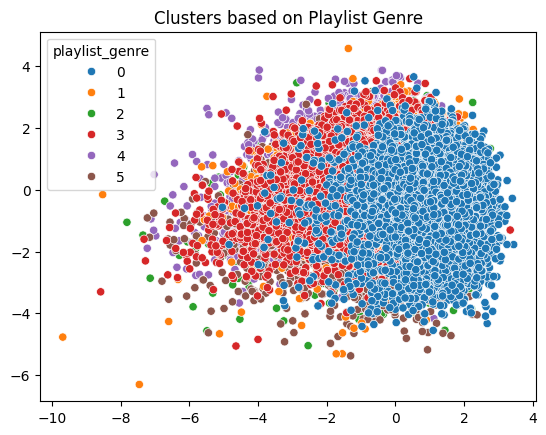

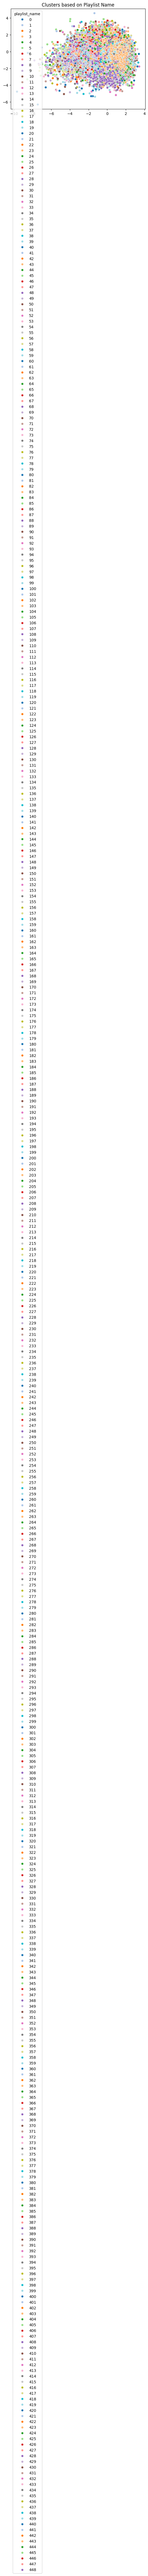

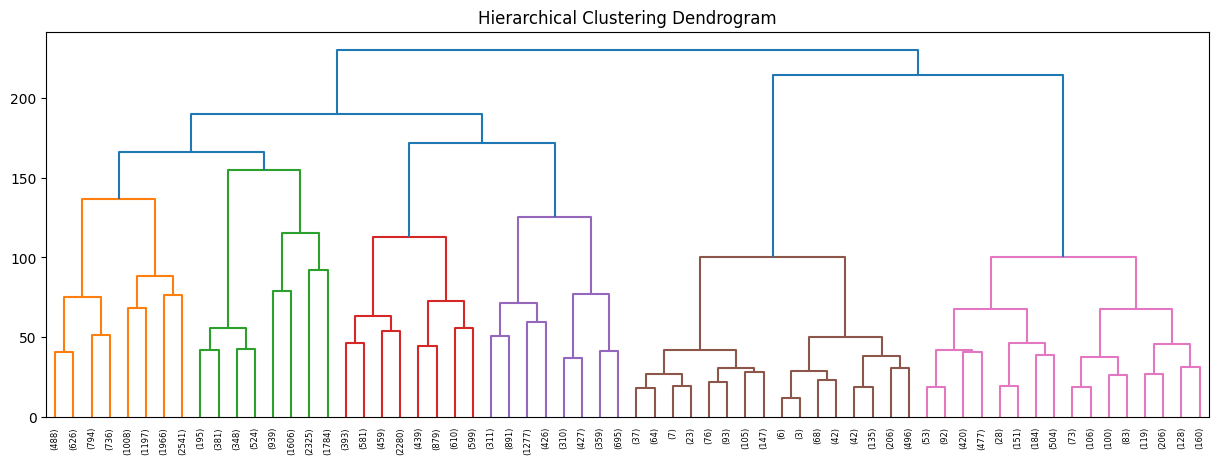

,track_name,track_artist,playlist_genre
5,1919,2782,2
24604,137,47,3
29676,1919,2782,0
2946,4359,4335,2
1520,3087,2424,2


In [ ]:
#SPOTIFY SONGS GENRE SEGMENTATION [Minor]

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram, linkage

#load dataset
df = pd.read_csv("spotify dataset.csv")

#DATA PREPROCESSING

#removed duplicates and missing values
df = df.drop_duplicates()
df = df.dropna()

#category
cat_cols = ['track_name','track_artist','playlist_genre','playlist_name']
encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

#numerical columns
num_cols = df.select_dtypes(include=['int64','float64']).columns

#scale all numeric features
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[num_cols] = scaler.fit_transform(df[num_cols])

#EDA and VISUALISATIONS

#distribution of all numerical feature
df[num_cols].hist(figsize=(16,12))
plt.tight_layout()
plt.show()

#boxplots to check outliers
plt.figure(figsize=(16,10))
df[num_cols].plot(kind='box')
plt.xticks(rotation=90)
plt.show()

df.select_dtypes(include='number').boxplot(figsize=(16,10))
plt.xticks(rotation=90)
plt.show() #check

#playlist genre frequency
plt.figure(figsize=(10,5))
df['playlist_genre'].value_counts().plot(kind='bar')
plt.title("Distribution of Playlist Genres")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.show()

#playlist name frequency (Top 15)
plt.figure(figsize=(12,5))
df['playlist_name'].value_counts().head(15).plot(kind='bar')
plt.title("Top 15 Playlist Names")
plt.xticks(rotation=75)
plt.show()

#pairplot for key features
sns.pairplot(df[['danceability','energy','valence','tempo']])
plt.show()

#correlation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(df[num_cols].corr(), cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

#CLUSTERING ANALYSIS

#finding opti k
inertia = []
K = range(2,12)
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(df_scaled[num_cols])
    inertia.append(km.inertia_)

plt.plot(K, inertia, marker='o')
plt.title("Elbow Method")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.show()

#silhouette score for better validation
best_k = 0
best_score = -1
for k in range(2,12):
    km = KMeans(n_clusters=k, random_state=42).fit(df_scaled[num_cols])
    labels = km.labels_
    score = silhouette_score(df_scaled[num_cols], labels)
    if score > best_score:
        best_score = score
        best_k = k

best_k, best_score  #cluster count

#final K-means model
kmeans = KMeans(n_clusters=best_k, random_state=42)
df_scaled['cluster'] = kmeans.fit_predict(df_scaled[num_cols])

#PCA for visualization
pca = PCA(n_components=2)
pca_out = pca.fit_transform(df_scaled[num_cols])

plt.figure(figsize=(10,7))
plt.scatter(pca_out[:,0], pca_out[:,1], c=df_scaled['cluster'])
plt.title("Cluster Visualization using PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

#CLUSTERS BY PLAYLIST GENRE
sns.scatterplot(x=pca_out[:,0], y=pca_out[:,1],
                hue=df['playlist_genre'], palette="tab10")
plt.title("Clusters based on Playlist Genre")
plt.show()

# CLUSTERS BY PLAYLIST NAME
sns.scatterplot(x=pca_out[:,0], y=pca_out[:,1],
                hue=df['playlist_name'], palette="tab20")
plt.title("Clusters based on Playlist Name")
plt.show()

#EXTRA: HIERARCHICAL CLUSTERING (DENDROGRAM)
Z = linkage(df_scaled[num_cols], method='ward')
plt.figure(figsize=(15,5))
dendrogram(Z, truncate_mode='level', p=5)
plt.title("Hierarchical Clustering Dendrogram")
plt.show()

#RECOMMENDATION SYSTEM (content based)

#cosine similarity
similarity = cosine_similarity(df_scaled[num_cols])

#simple recommendation fxn
def recommend(track_index, top_n=5):
    scores = list(enumerate(similarity[track_index]))
    scores = sorted(scores, key=lambda x: x[1], reverse=True)
    top_items = scores[1:top_n+1]
    return df.iloc[[i[0] for i in top_items]][['track_name','track_artist','playlist_genre']]

#example result
recommend(10, top_n=5)